In [68]:
import pandas as pd
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

train=pd.read_csv('train.csv')
campaign_data=pd.read_csv('campaign_data.csv')
coupon_item_mapping=pd.read_csv('coupon_item_mapping.csv')
customer_demographics=pd.read_csv('customer_demographics.csv')
customer_transaction_data=pd.read_csv('customer_transaction_data.csv')
item_data=pd.read_csv('item_data.csv')
test=pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

data = pd.concat([train, test], sort=False).reset_index(drop = True)
ltr = len(train)
data = data.merge(campaign_data, on='campaign_id')#  campaign_data
data = data.merge(customer_demographics, on='customer_id',how='left') #  customer_demographics
data = pd.merge_asof(data.sort_values("customer_id"), customer_transaction_data.sort_values("customer_id"), on='customer_id')
data = pd.merge_asof(data.sort_values("item_id"), item_data.sort_values("item_id"), on='item_id')
#data['start_date'] = pd.to_datetime(data['start_date'])
#data['end_date'] = pd.to_datetime(data['end_date'])
#data['date'] = pd.to_datetime(data['date'])


for i in data.columns:
    if str(data[i].dtype) == 'object':
        data[i] = data[i].factorize()[0]

train_cols = ['id','campaign_id', 'coupon_id', 'customer_id',
       'campaign_type', 'age_range','marital_status', 'rented', 'family_size', 'no_of_children',
       'income_bracket', 'item_id', 'quantity', 'selling_price',
       'other_discount', 'coupon_discount', 'brand', 'brand_type', 'category']

data[train_cols] = data[train_cols].fillna(data[train_cols].mean())
train = data[data['redemption_status'].notnull()]
test = data[data['redemption_status'].isnull()]



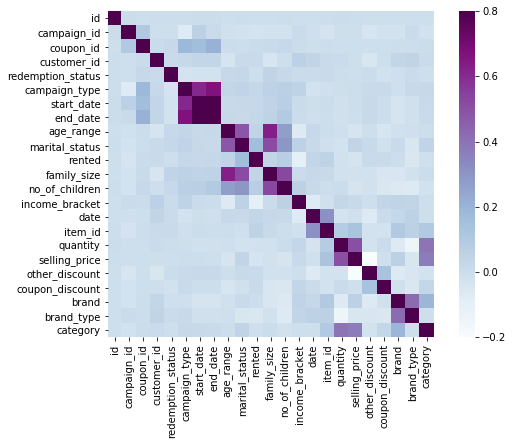

In [69]:
matrix = train.corr()
ax = plt.subplots(figsize=(9, 6))
sns.heatmap(matrix, vmax=.8, square=True, cmap="BuPu");

In [70]:
train.isnull().sum()

id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
campaign_type        0
start_date           0
end_date             0
age_range            0
marital_status       0
rented               0
family_size          0
no_of_children       0
income_bracket       0
date                 0
item_id              0
quantity             0
selling_price        0
other_discount       0
coupon_discount      0
brand                0
brand_type           0
category             0
dtype: int64

In [71]:
#Model building
X = train.drop('redemption_status',1) 
y = train.redemption_status

In [72]:
from sklearn.model_selection import train_test_split

x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.3)

In [73]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score

model = LogisticRegression() 
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,penalty='l2', random_state=1, solver='liblinear', tol=0.0001,verbose=0, warm_start=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [74]:

#Let’s predict the Loan_Status for validation set and calculate its accuracy.

pred_cv = model.predict(x_cv)

#Let us calculate how accurate our predictions are by calculating the accuracy.

accuracy_score(y_cv,pred_cv)

0.9908978775892135

In [75]:
test=test.drop('redemption_status',1)

In [76]:
pred_test = model.predict(test)

In [77]:
pred_test

array([0., 0., 0., ..., 0., 0., 0.])

In [95]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50226 entries, 0 to 128575
Data columns (total 22 columns):
id                 50226 non-null int64
campaign_id        50226 non-null int64
coupon_id          50226 non-null int64
customer_id        50226 non-null int64
campaign_type      50226 non-null int64
start_date         50226 non-null int64
end_date           50226 non-null int64
age_range          50226 non-null int64
marital_status     50226 non-null int64
rented             50226 non-null float64
family_size        50226 non-null int64
no_of_children     50226 non-null int64
income_bracket     50226 non-null float64
date               50226 non-null int64
item_id            50226 non-null int64
quantity           50226 non-null int64
selling_price      50226 non-null float64
other_discount     50226 non-null float64
coupon_discount    50226 non-null float64
brand              50226 non-null int64
brand_type         50226 non-null int64
category           50226 non-null int64


In [97]:
submission = pd.DataFrame()
submission['id'] = test.id.values
submission['redemption_status'] = pred_test

In [90]:
test['id'].unique()

array([ 11580,  23134,  38200, ..., 116319,  38443,  21080], dtype=int64)

In [99]:
submission['redemption_status'].unique()

array([0.])

In [101]:
pd.DataFrame(submission, columns=['id','redemption_status']).to_csv('submission.csv', index=False)